### 1.1 Import packages

Import general python packages, LSST packages, PyVO packages, and Astropy packages.

In [1]:
import time
import numpy as np
import uuid
import os
import glob
import math
import pandas
import matplotlib.pyplot as plt
import tempfile
import getpass
from PIL import Image
from IPython.display import Image as dimg

import lsst.geom as geom
import lsst.resources
import lsst.afw.display as afwDisplay
from lsst.afw.image import Exposure, ExposureF
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
from lsst.rsp import get_tap_service
from lsst.rsp.utils import get_access_token
from lsst.afw.fits import MemFileManager

import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.io import fits
from astropy.wcs import WCS

import scarlet2
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import skew
import getpass

import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
from lsst.geom import Point2D, radToDeg, SpherePoint, degrees

from astropy.wcs import WCS
from astropy.io import fits
import jax.numpy as jnp
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
from lsst.afw.detection import Psf
from lsst.meas.algorithms import WarpedPsf
#from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
#from lsst.meas.algorithms.detection import SourceDetectionTask
#from lsst.meas.deblender import SourceDeblendTask
#from lsst.meas.base import SingleFrameMeasurementTask
#from lsst.meas.base import ForcedMeasurementTask

### 1.2 Define parameters and functions

#### 1.2.1 Set plotting parameters

Set the backend for `afwDisplay` to `matplotlib`.
Set parameters for plots.

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }
plt.style.use('tableau-colorblind10')

plt.rcParams.update(params)

When displaying `pandas` tables in the notebook,
only display up to 20 rows.

In [3]:
pandas.set_option('display.max_rows', 20)

#### 1.2.2 Set up the temporary directory

The Rubin cutout service allows the user to save cutouts as fits files locally on the Rubin Science Platform (RSP).

RSP users should save temporary files in the shared `/scratch` directory, in sub-directories named with their RSP username.

Get the username and ensure an appropriate `/scratch` sub-directory exists.

In [4]:
username = getpass.getuser()
print('username: ', username)

userdir = '/deleted-sundays/' + username
if not os.path.exists(userdir):
    os.makedirs(userdir)
    print('Created ', userdir)
else:
    print('Directory already existed: ', userdir)

username:  charlotteward
Directory already existed:  /deleted-sundays/charlotteward


Within that folder, create a sub-folder named `dp02_13a_temp` in which to save files created by this tutorial.
At the end of the notebook, the last cell will clear the contents and remove this temporary folder.

In [5]:
tempdir = userdir + '/dp02_13a_temp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    print('Created ', tempdir)
else:
    print('Directory already existed: ', tempdir)

Directory already existed:  /deleted-sundays/charlotteward/dp02_13a_temp


Delete the `username` and `userdir`, but keep `tempdir` to be used.

In [6]:
del username, userdir

#### 1.2.3 Create functions

Create the function `plot_image` to enable easy plotting of files from the cutout tool.

In [7]:
def plot_image(exposure: ExposureF):
    """Plot and image using lsst.awf.image package

   Parameters
    ----------
    exposure : `ExposureF`
        the image to plot from file in LSST awf image exposure class format

   Returns
    -------
    image for notebook display
    """

    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()

Create the function `get_cutout` to retrieve the cutout and hold it in memory as an `ExposureF`.

In [8]:
def read_cutout_mem(sq):
    """Read the cutout into memory

    Parameters
    ----------
    sq : 'dict'
        returned from SodaQuery.from_resource()

    Returns
    -------
    exposure : 'ExposureF'
        the cutout in exposureF format
    """

    cutout_bytes = sq.execute_stream().read()
    sq.raise_if_error()
    mem = MemFileManager(len(cutout_bytes))
    mem.setData(cutout_bytes, len(cutout_bytes))
    exposure = ExposureF(mem)

    return exposure

Create the function `make_image_cutout`.

This is a wrapper function that will call the cutout tool and create image cutouts:

1. define the location on the sky
2. query the TAP service for the specifications of the `dataId`
3. retrieve the datalink URL associated with the data
4. create a cutout instance from the query result and the Datalink Resource
5. return the cutout as an `ExposureF` format image

In [9]:
def make_image_cutout(tap_service, ra, dec, dataId, cutout_size=0.01,
                      imtype=None, filename=None):
    """Wrapper function to generate a cutout using the cutout tool

   Parameters
    ----------
    tap_service : an instance of the TAP service
    ra, dec : 'float'
        the ra and dec of the cutout center
    dataId : 'dict'
        the dataId of the image to make a cutout from. The format
        must correspond to that provided for parameter 'imtype'
    cutout_size : 'float', optional
        edge length in degrees of the cutout
    imtype : 'string', optional
        string containing the type of LSST image to generate
        a cutout of (e.g. deepCoadd, calexp). If imtype=None,
        the function will assume a deepCoadd.
    filename : 'string', optional
        filename of the resulting cutout (which has fits format)

   Returns
    -------
    exposure : 'ExposureF'
        the cutout in exposureF format
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

    if imtype == 'calexp':

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_visit, lsst_detector, lsst_band " + \
            "FROM dp02_dc2_catalogs.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(dataId["visit"]) + " " + \
            "AND lsst_detector = " + str(dataId["detector"])
        results = tap_service.search(query)

    else:
        # Find the tract and patch that contain this point
        tract = dataId["tract"]
        patch = dataId["patch"]

        # add optional default band if it is not contained in the dataId
        band = dataId["band"]

        query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_patch, lsst_tract, lsst_band " + \
            "FROM dp02_dc2_catalogs.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(tract) + " " + \
            "AND lsst_patch = " + str(patch) + " " + \
            "AND lsst_band = " + "'" + str(band) + "' "
        results = tap_service.search(query)

    # Get datalink
    dataLinkUrl = results[0].getdataurl()
    auth_session = service._session
    dl = DatalinkResults.from_result_url(dataLinkUrl,
                                         session=auth_session)

    # from_resource: creates a instance from
    # a number of records and a Datalink Resource.
    sq = SodaQuery.from_resource(dl,
                                 dl.get_adhocservice_by_id("cutout-sync"),
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
                 spherePoint.getDec().asDegrees() * u.deg,
                 cutout_size * u.deg)

    exposure = read_cutout_mem(sq)

    # cutout_bytes = sq.execute_stream().read()
    # mem = MemFileManager(len(cutout_bytes))
    # mem.setData(cutout_bytes, len(cutout_bytes))
    # exposure = ExposureF(mem)
    
    return exposure


Create three functions to warp and scale a `calexp` cutout (which can have any rotated orientation on the sky) and combine them into an animated gif, to be used in Section 4.

* `warp_image`: rotate and scale the image to a common grid
* `get_minmax_xy`: determine the bounding box of the cutouts
* `make_gif`: combine warped images into an animated gif

In [10]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):
    """Warp and rotate an image onto the coordinate system of another image

   Parameters
    ----------
    ref_img: 'ExposureF'
        is the reference image for the re-projection
    img_to_warp: 'ExposureF'
        the image to rotate and warp onto the reference image's wcs
    ref_wcs: 'wcs object'
        the wcs of the reference image (i.e. ref_img.getWcs() )
    wcs_to_warp: 'wcs object'
        the wcs of the image to warp (i.e. img_to_warp.getWcs() )
   Returns
    -------
    warpedExp: 'ExposureF'
        a reprojected, rotated image that is aligned and matched to ref_image
     """
    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

In [11]:
def make_gif(folder):
    """Generate a GIF for all *.png images contained in a folder

   Parameters
    ----------
    # folder: 'string'
        string containing the path to the folder
        default filename is animation.gif

   Returns
    -------
     """
    frames = [Image.open(img) for img in sorted(glob.glob(f"{folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(folder+"/animation.gif", format="GIF",
                   append_images=frames, save_all=True, duration=500, loop=1)

## 2. Pull cutouts associated with a transient using the Rubin Image Cutout Service

This section will demonstrate a simple example: how to create a cutout for a single part of sky from a deepCoadd. 


### 2.1 Initiate the TAP service
The TAP service is used to query the dp02_dc2_catalogs.ObsCore table for the datalink (a web URL identifying where the data is hosted).

In [12]:
service = get_tap_service("tap")

### 2.2 Query for the source information needed to plot images before and after the transient event

This example will use a known diaObject with ID 1250953961339360185 (one identified and studied in DP0.2 tutorial notebook 07a). The cell below will retrieve the information needed to generate a set of images in order of time, including and after the transient event. The TAP query will identify 8 diaSource IDs measured for this diaObject at the ra/dec, and will also retrieve the ccdVisitId of each time the diaSource was observed in a calexp image.  

The last line will sort the query return by date, so that they appear in the correct chronological order.

In [13]:
diaObjectId = 1250953961339360185
query = "SELECT ra, decl, diaObjectId, diaSourceId, "\
        "psFlux, psFluxErr, filterName, midPointTai, "\
        "SNR, ccdVisitId, "\
        "scisql_nanojanskyToAbMag(psFlux) AS psAbMag "\
        "FROM dp02_dc2_catalogs.DiaSource "\
        "WHERE diaObjectId = " + str(diaObjectId) \
        + "ORDER BY midPointTai"
print(query)

SELECT ra, decl, diaObjectId, diaSourceId, psFlux, psFluxErr, filterName, midPointTai, SNR, ccdVisitId, scisql_nanojanskyToAbMag(psFlux) AS psAbMag FROM dp02_dc2_catalogs.DiaSource WHERE diaObjectId = 1250953961339360185ORDER BY midPointTai


The next cell shows the TAP query for the metadata that is associated with the image's remote location in the LSST data archive. The DP0.2 has a schema (table collection) called "dp02_dc2_catalogs", which contains a table called dp02_dc2_catalogs.ObsCore. The IVOA-defined `ObsCore` table contains generic metadata for the DP0.2 datasets. The table is accessible via ADQL queries via a TAP endpoint. The mechanism for locating the images LSST is to use the TAP service to query the `ObsCore` schema. 

In [14]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [15]:
diaSrc = job.fetch_result().to_table()

The next cell will retrieve calexp cutouts for each of the dia sources in the query, and plot them. Vmin and vmax set a common scaling so that the image scale is not skewed by a bright neighbor, and emphasizes the lower brightness sources such as the dia source. Each figure also is labeled by the time since the first difference image ($\Delta$t in units MJD).

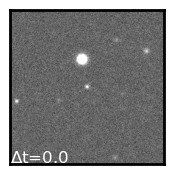

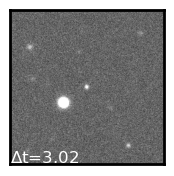

In [16]:
%matplotlib inline

ra = diaSrc['ra'][0]
dec = diaSrc['decl'][0]
vmin = -200
vmax = 300    
i=0
for src in diaSrc[:2]:
    ccdvisitID = src['ccdVisitId']
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)

    dataId_calexp = {'visit':visit, 'detector':detector}
    test = make_image_cutout(service, ra, dec, cutout_size=0.007,
                             imtype='calexp', dataId=dataId_calexp,
                             filename='cutout_'+str(i)+'.fits')

    fig, ax1 = plt.subplots(1, 1, figsize=(2, 2))

    ax1.imshow(test.image.array, cmap='gray', 
               vmin=vmin, vmax=vmax, origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(.1, .9,r'$\Delta$t=' + str(round(src['midPointTai']-diaSrc['midPointTai'][0],3)),
                color='white',fontsize=12)
    plt.show()
    i = i+1

    del dataId_calexp, test

### 2.3 Align the calexp images of the transient

In the above plots, it is clear that the calexp image orientations are not aligned with each other, because the calexp images are not necessarily all taken in the same position angle on the sky. The cell below will go through each dia source, identify the calexp file in which it was identified, and create cutouts (as above) except now they will all be aligned with each other. At the same time as creating these new aligned fits files for each cutout, the cell will create png files that will be useful for visualizing the transient behavior (to be used in Section 4.3).

The `cutout_size` variable is in units of degrees, converted from `cutout_size_pix` using the LSST Science Camera platescale of 0.2 arcseconds per pixel.

WarpedPsf()

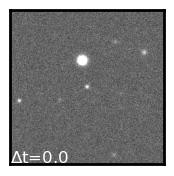

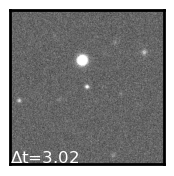

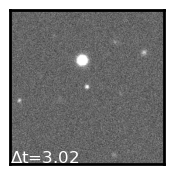

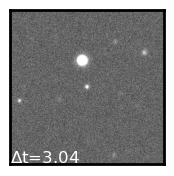

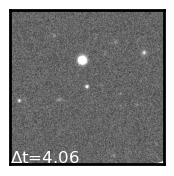

In [18]:
i = 0
cutout_size_pix = 131
cutout_size = cutout_size_pix * 0.2 / 3600.0

observations=[]
channels_sc2=[]
for i,src in enumerate(diaSrc[:5]):
    ccdvisitID = src['ccdVisitId']
    band = str(src['filterName'])
    visit = str(ccdvisitID)[:-3]
    detector = str(ccdvisitID)[-3:]
    visit = int(visit)
    detector = int(detector)
    dataId_calexp = {'visit': visit, 'detector': detector} 
    
    if i == 0:
        img_ref = make_image_cutout(service, ra, dec, cutout_size=cutout_size,
                                    imtype='calexp', dataId=dataId_calexp)      
        im_arr = img_ref.image.array                                   
        var_arr = img_ref.variance.array                                    
        N1,N2 = im_arr.shape
        image_sc2 = im_arr.reshape(1, N1,N2)
        N1,N2 = var_arr.shape
        weight_sc2 = 1/var_arr.reshape(1, N1,N2)
        info_calexp = img_ref.getInfo()
        psf_calexp = info_calexp.getPsf()
        point_tuple = (int(img_ref.image.array.shape[0]/2),int(img_ref.image.array.shape[1]/2))
        point_image = Point2D(point_tuple)
        psf_ref = psf_calexp.computeImage(point_image).convertF()
        N1,N2 = psf_ref.array.shape
        psf_sc2 = psf_ref.array.reshape(1, N1,N2)
        filename = os.path.join(tempdir,'cutout_' + str(i) + '.fits')
        img_ref.writeFits(filename)
        f=fits.open(filename)
        wcs_ref = WCS(f[1].header)

        obs = scarlet2.Observation(jnp.array(image_sc2).astype(float),
                           weights=jnp.array(weight_sc2).astype(float),
                           psf=scarlet2.ArrayPSF(jnp.array(psf_sc2).astype(float)),
                           wcs=wcs_ref,
                           channels=[(band,str(i))])
        channels_sc2.append((band,str(i)))
        observations.append(obs)
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)
        figname = os.path.join(tempdir, 'cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()
        #del minmax, im_arr
    else:
        img = make_image_cutout(service, ra, dec, cutout_size=cutout_size*50.0,
                                imtype='calexp', dataId=dataId_calexp)
        img_warped = warp_img(img_ref, img, img_ref.getWcs(), img.getWcs())
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
        im_arr = img_warped.image.array
        var_arr = img_warped.variance.array
        N1,N2 = im_arr.shape
        image_sc2 = im_arr.reshape(1, N1,N2)
        N1,N2 = var_arr.shape
        weight_sc2 = 1/var_arr.reshape(1, N1,N2)
        info_calexp = img.getInfo()
        psf_calexp = info_calexp.getPsf()
        point_tuple = (int(img_warped.image.array.shape[0]/2),int(img_warped.image.array.shape[1]/2))
        point_image = Point2D(point_tuple)
        psf = psf_calexp.computeImage(point_image).convertF()
        xyTransform = afwGeom.makeWcsPairTransform(img.wcs,img_warped.wcs)
        psf_w = WarpedPsf(img.getPsf(), xyTransform)
        point_tuple = (int(img_warped.image.array.shape[0]/2),int(img_warped.image.array.shape[1]/2))
        point_image = Point2D(point_tuple)
        psf_warped = psf_w.computeImage(point_image).convertF()
        if np.sum(psf_warped.array)==0:
            print('PSF model unavailable, skipping')
            continue
        N1,N2 = psf_warped.array.shape
        psf_sc2 = psf_warped.array.reshape(1, N1,N2)
        filename = os.path.join(tempdir, 'cutout_' + str(i) + '.fits')
        img_ref.writeFits(filename)
        f=fits.open(filename)
        wcs = WCS(f[1].header)
        obs = scarlet2.Observation(jnp.array(image_sc2).astype(float),
                           weights=jnp.array(weight_sc2).astype(float),
                           psf=scarlet2.ArrayPSF(jnp.array(psf_sc2).astype(float)),
                           wcs=wcs,
                           channels=[(band,str(i))])
        channels_sc2.append((band,str(i)))
        observations.append(obs)
        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(.1, .9, r'$\Delta$t='
                + str(round(src['midPointTai']-diaSrc['midPointTai'][0], 2)),
                color='white', fontsize=12)
        figname = os.path.join(tempdir, 'cutout_' + str(i) + '.png')
        if os.path.isfile(figname):
            os.remove(figname)
        plt.savefig(figname)
        plt.show()
        plt.close()
        #del minmax, im_arr, img_warped, img
    #i += 1
#del img_ref

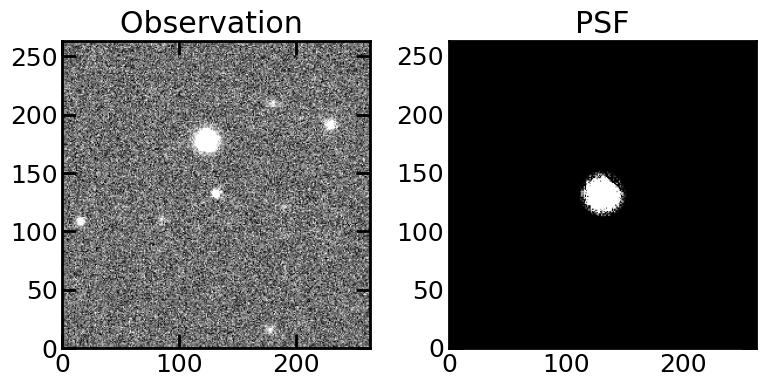

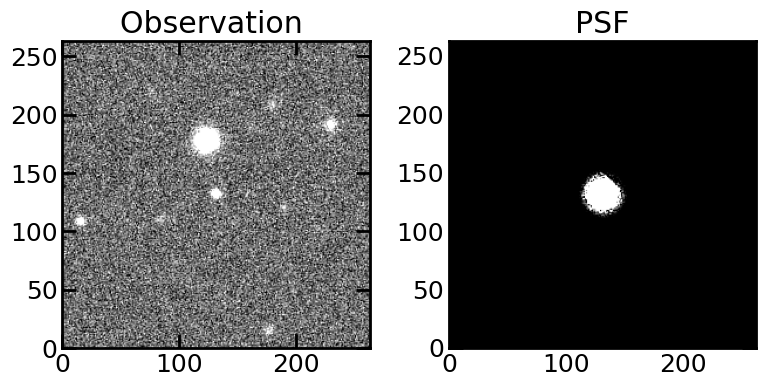

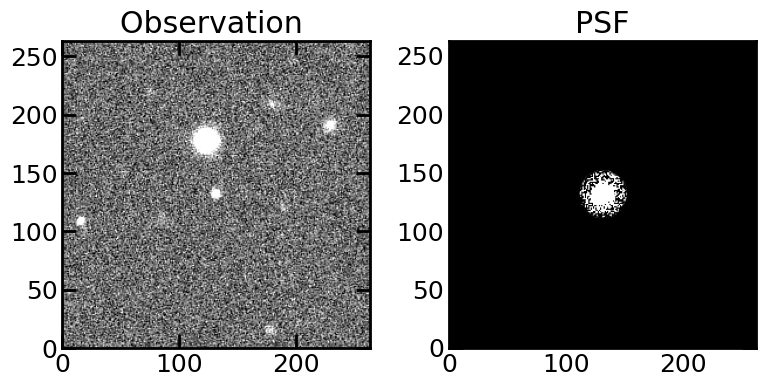

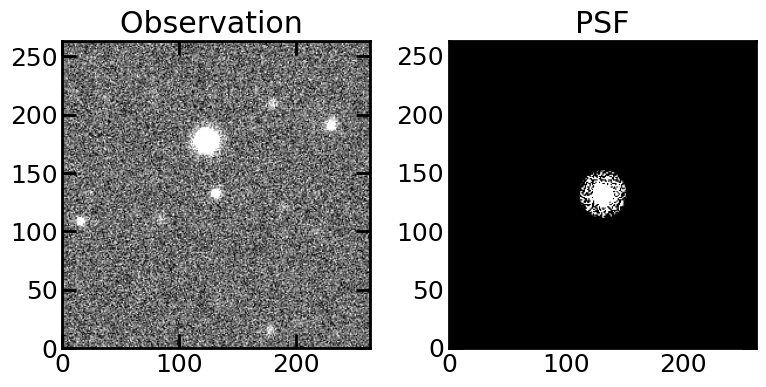

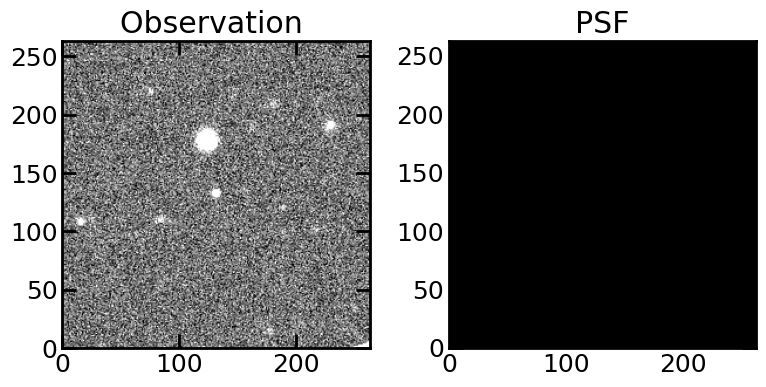

In [19]:
for obs in observations:
    scarlet2.plot.observation(obs, show_psf=True, add_labels=True)

Define Transient Scene
We first need to define a model frame, which covers the same sky area as the data. As the ZTF PSF is not well-sampled, we reduce the internal model PSF to a very narrow Gaussian:

In [20]:
model_psf = scarlet2.GaussianPSF(sigma=0.5)
model_frame = scarlet2.Frame.from_observations(obs, model_psf=model_psf)

Query the sources present in the Rubin catalogs that are within the cutout

In [21]:
center_coords = '"'+str(ra)+', '+str(dec)+'"'
coord_transient = SkyCoord(ra = ra * u.deg, dec=dec * u.deg)
max_rec=100
center_coords = "60.2901272, -44.1420532"

query = "SELECT TOP " + str(max_rec) + " " + \
        "objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract " + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + center_coords + ", " + str(cutout_size) + ")) = 1 " + \
        "AND detect_isPrimary = 1" + \
        "AND scisql_nanojanskyToAbMag(g_ap09Flux) < 24.5 "
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
results = job.fetch_result()
source = results.to_table()
coords = SkyCoord(ra=np.asarray(source['coord_ra'],dtype=float) * u.deg, dec=np.asarray(source['coord_dec'],dtype=float) * u.deg)

Job phase is COMPLETED


DALServiceError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
coord_arr = np.column_stack((np.asarray(source['coord_ra'],dtype=float),np.asarray(source['coord_dec'],dtype=float)))
catalog_pix = wcs_ref.wcs_world2pix(coord_arr,1)
catalog_keep = np.argwhere((catalog_pix[:,0]<img_ref.image.array.shape[0])&(catalog_pix[:,0]>0)&(catalog_pix[:,1]<img_ref.image.array.shape[1])&(catalog_pix[:,1]>0))[:,0]
coord_arr_init = coord_arr[catalog_keep]

In _scarlet2_ we treat transients as sources that have independent amplitudes in every band and epoch (defined by {py:class}`~scarlet2.TransientArraySpectrum`), while static sources only have independent amplitudes in every band, i.e. their `spectrum` are shared across all epochs (implemented in {py:class}`~scarlet2.StaticArraySpectrum`). If we know that the transient is "off" for some epochs (e.g. pre-explosion), we can set those amplitudes to zero.

As our model frame treats the channels as a combined (band, epoch) identifier, the `spectrum` attributes for every source inherit this overloaded definition. So, we need to take care to set/fit the elements of this generalized spectrum vector correctly. For that purpose, we define lookup functions (`band_selector` and `epoch_selector`), which operate on the channel information and return the band or the epoch, respectively.

We can now define a {py:class}`~scarlet2.Scene`:

In [ ]:
# separate channel information into band and epoch: 0 and 1 element
# depends on how channels encodes multi-epoch information
band_selector = lambda channel: channel[0]
epoch_selector = lambda channel: channel[1]
bandsall = np.asarray([c[0] for c in channels_sc2],dtype=str)
epochsall = np.asarray([c[1] for c in channels_sc2],dtype=str)
bands, band_index = np.unique(bandsall,return_index=True)
bandsunique = list(map(str,bands))
epochsall = list(map(str,epochs))
with scarlet2.Scene(model_frame) as scene:
    #First, initialize the transient
    spectrum = scarlet2.init.pixel_spectrum(obs, coord_transient)
    scarlet2.PointSource(
        coord_transient, scarlet2.TransientArraySpectrum(spectrum, epochs=epochsall, epoch_selector=epoch_selector)
    )
    for i, center in enumerate(coords):    
        #Now initialize background sources that are static across epochs
        try:
            spectrum, morph = scarlet2.init.from_gaussian_moments(observations, center)
            # If the boxes produced are too small, try adjusting the SNR or box_size arguments https://github.com/pmelchior/scarlet2/blob/8a7bf55f4908a402ba7e43b4b564886aa4ad2a4b/src/scarlet2/init.py#L205
        except:# IndexError:
            morph = scarlet2.init.compact_morphology()
            spectrum = scarlet2.init.pixel_spectrum(obs, center)
        # the host is barely resolved and the data are noisy:
        # use a starlet morphology for extra stability (esp to noise)
        morph = scarlet2.StarletMorphology.from_image(morph)
        # Select the transient-free epochs to initialize amplitudes for the static source
        # These will be shared across all epochs
        spectrum = spectrum[band_index]
        scarlet2.Source(
            center, scarlet2.StaticArraySpectrum(spectrum, bands=bandsunique, band_selector=band_selector), morph
        )
       

## Fitting

Fitting works as usual by defining the {py:class}`~scarlet2.Parameters`. Because the two spectra and the host morphology (of type {py:class}`~scarlet2.StarletMorphology`) aren't simple arrays but models themselves, their free parameters are the array attributes `.data` and `.coeffs`, respectively, as show in the source definition above, e.g. `TransientArraySpectrum(data=f32[4],...)`. These fundamental degrees of freedom of the scene is what we have to pass to the parameters class:

In [ ]:
from numpyro.distributions import constraints

pos_step = 1e-2
morph_step = lambda p: scarlet2.relative_step(p, factor=1e-2)
SED_step = lambda p: scarlet2.relative_step(p, factor=1e-2)

parameters = scene.make_parameters()

parameters += scarlet2.Parameter(scene.sources[0].spectrum.data, name=f"spectrum.{0}", stepsize=SED_step)
parameters += scarlet2.Parameter(
    scene.sources[0].center, name=f"center.{0}", constraint=constraints.positive, stepsize=pos_step
)

for i, center in enumerate(coords):
        # Static host galaxy parameters
        parameters += scarlet2.Parameter(
            scene.sources[i+1].spectrum.data, name=f"spectrum.{i+1}", constraint=constraints.positive, stepsize=SED_step
        )
        parameters += scarlet2.Parameter(
            scene.sources[i+1].morphology.coeffs,
            name=f"morph.{i+1}",
            stepsize=morph_step,
        )

    

In [ ]:
scarlet2.plot.scene(
    scene,
    observation=obs,
    norm=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=False,
    split_channels=False,
    box_kwargs={"edgecolor": "red", "facecolor": "none"},
    label_kwargs={"color": "red"},
)
plt.show()

In [ ]:
# Fit the scene
stepnum = 2000
scene_ = scene.fit(obs, parameters, max_iter=stepnum, e_rel=1e-7, progress_bar=False)

In [ ]:
# Plot the model, for each epoch
scarlet2.plot.scene(
    scene_,
    observation=obs,
    norm=None,
    show_model=False,
    show_observed=True,
    show_rendered=True,
    show_residual=True,
    add_labels=True,
    add_boxes=True,
    split_channels=False,
    box_kwargs={"edgecolor": "red", "facecolor": "none"},
    label_kwargs={"color": "red"},
)
plt.show()


In [ ]:
#Print the best fitting fluxes
print("----------------- {}".format(channels))
for k, src in enumerate(scene_.sources):
    print("Source {}, Fluxes: {}".format(k, scarlet2.measure.flux(src)))

In [ ]:
scarlet2.plot.sources(
    scene_,
    norm=None,
    observation=obs,
    show_model=True,
    show_rendered=True,
    show_observed=True,
    show_spectrum=False,
    add_markers=False,
    add_boxes=True,
)
plt.show()

## 5. Remove the temp folder

As mentioned in Section 1.2.2, empty the temporary folder.

1. List the contents of the temp folder.
2. Remove each file in the temp folder, one at a time.
3. List again the contents of the temp folder to see it is empty.
4. Delete the temp folder itself.

In [ ]:
os.system('ls ' + tempdir)
for filepath in glob.glob(os.path.join(os.getenv('HOME'), tempdir + '/')+"*"):
    os.remove(filepath)
os.system('ls ' + tempdir)
os.system('rmdir ' + tempdir)